In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.base.elastic_net import RegularizedResults
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso, LassoCV, MultiTaskLassoCV
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller # ADFuller Hypothesis test
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU,LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping


Bad key "text.kerning_factor" on line 4 in
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Table of Contents

 - 1. [Model Preparation](#Model-Preparation)
 - 2. [Baseline Model](#Baseline-Model)
 - 3. [Linear Regression](#Linear-Regression)
 - 4. [LASSO Linear Regression](#LASSO-Linear-Regression )
 - 5. [PCA](#PCA )
 - 6. [Determining Time Series Order](#Determining-Time-Series-Order)
 - 7. [ARIMAX](#ARIMAX)
 - 8. [SARIMAX](#SARIMAX)
 - 9. [SARIMA Full Data](#SARIMA-Full-Data)
 - 10 .[VAR](#VAR) 
 - 11 .[RNN](#RNN) 
 - 12. [Model Selection](#Model-Selection)
 - 13. [Model Evaluation](#Model-Evaluation)
 - 14. [Conclusions/Recommendations](#Conclusions/Recommendations)

# Model Preparation

In [2]:

df = pd.read_csv("df_clean.csv")

In [3]:
df.index = df.index.astype(float)

In [4]:
df.set_index('year',inplace=True)

We initally split our data into train and test sets but then used a different to do this.

In [30]:
X = df.drop(columns = 'target')
y = df['target']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .2,shuffle=False)
sc = StandardScaler()
X_train_ss = sc.fit_transform(X_train)
X_test_ss = sc.transform(X_test)# We must scale the data before regularization
X_ss = sc.transform(X)


# Baseline Model

In [23]:
y_pred = y.mean()
baseline  = np.sqrt(((y-y_pred)**2).mean())
print(f'the baseline RMSE is {baseline}')

the baseline RMSE is 39301.05435707757


The baseline error for our data is an RMSE of 39k$ 

# Linear Regression

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)# fit linear regression model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
def rmse(y_true,y_pred):
    

    mse = mean_squared_error(y_true,y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [26]:
train_preds = lr.predict(X_train)
print(f'linear regression train RMSE is {rmse(y_train,train_preds)}')

linear regression train RMSE is 1119.9921847196501


In [246]:
test_preds = lr.predict(X_test)
print(f'linear regression test RMSE is {rmse(y_test,test_preds)}')


linear regression test RMSE is 2.89328714955734e+16


In [28]:
lr_scores = cross_val_score(lr, X, y, cv=5,scoring = make_scorer(rmse))
lr_scores.mean()

6359212817287235.0

The first attempt to predict permit values does worse than baseline.

We want to reduce the amount of features in the model, so we used LASSO regularization to reduce features

# LASSO Linear Regression

In [31]:
lasso_model = Lasso(10)
lasso_model.fit(X_train_ss, y_train)

/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 383091785.33500504, tolerance: 81492297.0550389
  positive)


Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [33]:
lasso_train_preds = lasso_model.predict(X_train_ss)
lasso_test_preds = lasso_model.predict(X_test_ss)

In [34]:
print(f'lasso train RMSE is {rmse(y_train,lasso_train_preds)}')
print(f'lasso test RMSE is {rmse(y_test,lasso_test_preds)}')

lasso train RMSE is 967.7451080264037
lasso test RMSE is 150762.98276643534


This model did not outperform baseline

In [35]:
lasso_coef = lasso_model.coef_

In [36]:
lasso_model_coef = pd.Series(lasso_coef[0], index = X_train.columns)
print('Lasso picked ' +  str(sum(lasso_model_coef != 0)) +  ' variables and eliminated the other '  + str(sum(lasso_model_coef == 0)) + ' variables ') 

Lasso picked 1368 variables and eliminated the other 0 variables 


it also didnt take out any features so this was unsuccesful

In [37]:
df = df.loc[:, (df != df.iloc[0]).any()]

# PCA

In [221]:
pca_99 = PCA(.99, random_state = 42)

Z_train = pca_99.fit_transform(X_train_ss)
Z_test = pca_99.transform(X_test_ss)
Z = pca_99.fit_transform(X_ss)


In order to perform feature reduction we used Principle Component Analysis to gather the Principle Components of our features and cpature 99% of the explained variance in our features. We created 26 new features that have all the variance of our 1306 features.

In [165]:
Z = (pd.DataFrame(Z, columns = [f"PC{i + 1}" for i in range(Z.shape[1])],index = X.index))

In [41]:
loadings = pca_99.components_.T * np.sqrt(pca_99.explained_variance_)

loading_matrix = pd.DataFrame(loadings, columns = [f"PC{i + 1}" for i in range(loadings.shape[1])],index=X.columns)


Lets examine of two our PCA features to see what they are made out of.

In [42]:
loading_matrix.sort_values(by="PC1", ascending = False)[["PC1"]].head(10)

,PC1
"('Aquaculture (metric tons)', 'Marshall Islands')",27.632069
"('Pounds', 'Norton Sound AYK Coho')",10.182972
"('Aquaculture (metric tons)', 'Burundi')",10.114997
"('Number Of Fish', 'Norton Sound AYK Coho')",7.676036
"('Fish and seafood supply per person (kilograms per year)', 'Afghanistan')",6.404615
"('Fish and seafood supply per person (kilograms per year)', 'Zambia')",4.818869
"('Capture fisheries (metric tons)', 'Laos')",4.731128
"('Capture fisheries (metric tons)', 'Armenia')",4.478039
"('Wholesale Average Price per Pound', 'Chinook Bristol Bay Fillets with skin & ribs')",4.384386
"('Aquaculture (metric tons)', 'Senegal')",3.766764


The most important pieces of PCA1 are metric related to Norton Sound Chinook, a highly correlated fishery to BB sockeye. Also featured prominently is capture fisheries for competitive markets. Especially Japan, this is a major market for BB salmon. 

In [43]:
loading_matrix.sort_values(by="PC1", ascending = False)[["PC1"]].tail(10)

,PC1
"('Capture fisheries (metric tons)', 'Latin America & Caribbean')",-1.113864
"('Capture fisheries (metric tons)', 'Latin America & Caribbean (IDA & IBRD)')",-1.117200
"('Fish and seafood supply per person (kilograms per year)', 'Senegal')",-1.154732
"('Fish and seafood supply per person (kilograms per year)', 'Belize')",-1.171162
"('Capture fisheries (metric tons)', 'Turkey')",-1.209956
"('Capture fisheries (metric tons)', 'Chile')",-1.237963
"('Fish and seafood supply per person (kilograms per year)', 'Turkey')",-1.244120
"('Aquaculture (metric tons)', 'France')",-1.271388
"('Capture fisheries (metric tons)', 'Turks and Caicos Islands')",-1.295392
"('Aquaculture (metric tons)', 'Syrian Arab Republic')",-1.393378


Negatively correlated components for PCA1 are competative markets as well and chum in PWS. Also, Norton Sound Sockeye shows up here as it is competitive product for BB sockeye.

In [44]:
loading_matrix.sort_values(by="PC2", ascending = False)[["PC2"]].head(10)

,PC2
"('Aquaculture (metric tons)', 'Marshall Islands')",15.490479
"('Aquaculture (metric tons)', 'Burundi')",2.295186
"('Capture fisheries (metric tons)', 'Guam')",1.117565
"('Capture fisheries (metric tons)', 'Lebanon')",1.050624
"('Capture fisheries (metric tons)', 'Brunei')",1.040345
"('Capture fisheries (metric tons)', 'Romania')",0.855625
"('Capture fisheries (metric tons)', 'Mauritius')",0.842878
"('Fish and seafood supply per person (kilograms per year)', 'Madagascar')",0.796959
"('Fish and seafood supply per person (kilograms per year)', 'Mali')",0.779323
"('Fish and seafood supply per person (kilograms per year)', 'Kiribati')",0.740961


Here we have chignik salmon represented with a a lot of variance and shrimp price, a metric used to determine the srength of the fishing industry

In [45]:
loading_matrix.sort_values(by="PC2", ascending = False)[["PC2"]].tail(10)

,PC2
"('Wholesale Average Price per Pound', 'Sockeye Southeast Whole fish/food fish')",-1.055085
"('Pounds', 'Norton Sound AYK Chum')",-1.060359
"('Estimated Exvessel Value (Nominal)', 'Cook Inlet Central Pink')",-1.061681
"('Estimated Exvessel Value (Nominal)', 'Norton Sound AYK Chum')",-1.096064
"('Aquaculture (metric tons)', 'Uruguay')",-1.108255
"('Estimated Exvessel Value (Nominal)', 'Norton Sound AYK Coho')",-1.118929
"('Number Of Fish', 'Norton Sound AYK Coho')",-1.201044
"('Estimated Exvessel Value (Nominal)', 'Bristol Bay Central Coho')",-1.305440
"('Capture fisheries (metric tons)', 'Botswana')",-1.324899
"('Pounds', 'Norton Sound AYK Coho')",-1.407106


Negative variance here is fishery data related to high seafood producing countries. 

We need to assure stationarity for our target variable. By using a dickey fuller test to determine the correct amount of differencing that we need. 

# Determining Time Series Order

In [46]:
def interpret_dftest(target_column):
    '''Returns the Test Statistic and p-value for Augmented Dickey-Fuller test on given target column'''
    dftest = adfuller(target_column)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

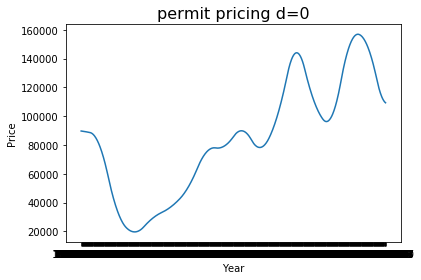

In [47]:

# d = 0
plt.plot(y);
plt.title(label='permit pricing d=0', fontsize = 16)
plt.xlabel("Year")
plt.ylabel("Price");

In [48]:
interpret_dftest(y)

Test Statistic   -0.811144
p-value           0.815827
dtype: float64

Without any differencing we do not have stationarity as our target failed the dickey fuller test. Lets try one diff.

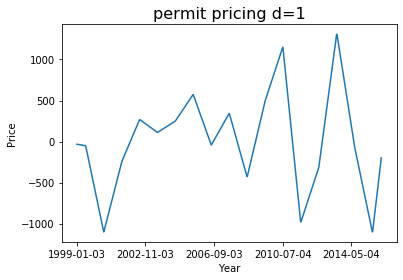

In [49]:
y.diff().plot()
plt.title(label='permit pricing d=1', fontsize = 16)
plt.xlabel("Year")
plt.ylabel("Price");

In [50]:
interpret_dftest(y.diff().dropna())

Test Statistic   -4.940128
p-value           0.000029
dtype: float64

This will work, we can use a column that includes the difference between each column and one samople before it. This will help us model our data over our desired time range.

Now we to determine the correct amount of Auto correlation to anticapate the shocks in our data over our time range.

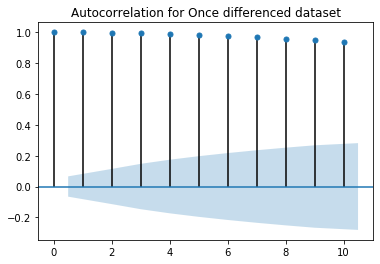

In [51]:
plot_acf(y.diff().dropna(), lags = 10)
plt.title("Autocorrelation for Once differenced dataset");

The ACF decline gradually between auto correlation 1 and 10.

/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


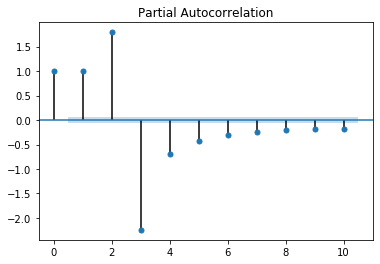

In [52]:

plot_pacf(y.diff().dropna(), lags = 10);

The PACF approaches 0 after the 3rd lag, so we know the correct lag order is 3.


In [53]:
y.dropna(inplace=True)
Z.dropna(inplace=True)

We now have 3 lags so the first 3 columns will be blank, we need to drop that data. We also know that ACF and PACF gradually declined to 0, so we dont need any MA component. 
 - d = 1
 - p = 3
 - q  = 0

We are going to start off without incorporating Seasonality into our data so far. So we have an ARIMA model

# ARIMAX Model

In [64]:
order = (3, 1, 0)


# instantiate
arimax = ARIMA(
    y, 
    exog = Z,
    order = order, 
    #freq = "W", # freq helps set the index column of predictions
    # ensure model is not trying to enfore stationarity (use d and D)
)

# fit
arimax = arimax.fit()

/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [55]:
arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.target   No. Observations:                  709
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -1606.553
Method:                       css-mle   S.D. of innovations              2.308
Date:                Sun, 07 Jun 2020   AIC                           3269.107
Time:                        15:26:50   BIC                           3396.895
Sample:                    01-10-1999   HQIC                          3318.475
                         - 08-05-2012                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             24.2424    123.499      0.196      0.844    -217.811     266.295
x1                 0.1987      0.526      0.378      0.706      -0.833       1.230
x2                -0.5678      0.702     -0.809      0.419      -1.944       0.808
x3                 1.9789      1.028      1.926      0.054      -0.035       3.993
x4                -0.3299      1.102     -0.299      0.765      -2.491       1.831
x5                -0.6035      0.861     -0.701      0.483      -2.290       1.083
x6                -0.3361      1.110     -0.303      0.762      -2.512       1.840
x7                -2.3569      1.318     -1.788      0.074      -4.940       0.226
x8                -0.0328      1.082     -0.030      0.976      -2.153       2.087
x9                -3.3468      1.634     -2.048      0.041      -6.550      -0.144
x10                0.3256      1.059      0.308      0.758      -1.749       2.400
x11                0.2662      1.041      0.256      0.798      -1.775       2.307
x12                1.2593      1.626      0.775      0.439      -1.927       4.446
x13               -1.9878      1.881     -1.057      0.291      -5.674       1.698
x14               -0.2610      0.295     -0.885      0.376      -0.839       0.317
x15               -1.9293      0.513     -3.764      0.000      -2.934      -0.925
x16               -0.0247      0.048     -0.510      0.610      -0.119       0.070
x17                0.1322      0.087      1.524      0.127      -0.038       0.302
x18               -0.3715      0.105     -3.550      0.000      -0.577      -0.166
x19                0.8720      0.669      1.303      0.193      -0.440       2.184
x20               -0.1925      0.126     -1.533      0.125      -0.439       0.054
x21               -0.4475      0.229     -1.953      0.051      -0.897       0.002
x22                0.8813      0.468      1.883      0.060      -0.036       1.799
x23               -0.1828      0.060     -3.040      0.002      -0.301      -0.065
ar.L1.D.target     2.4498      0.023    108.068      0.000       2.405       2.494
ar.L2.D.target    -1.9183      0.045    -42.597      0.000      -2.007      -1.830
ar.L3.D.target     0.4678      0.023     20.635      0.000       0.423       0.512
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0160           -0.0332j            1.0166           -0.0052
AR.2            1.0160           +0.0332j            1.0166            0.0052
AR.3            2.0683           -0.0000j            2.0683           -0.0000
-----------------------------------------------------------------------------
"""

In [147]:
starting_index = round(len(y.index) * .8) # starting split after 80% of observations are in "training" set

arimax_train = y.iloc[1:starting_index]

arimax_test  = y.iloc[starting_index:]

In [152]:
arimax_train_preds = arimax.predict(start = arimax_train.index[0], end = arimax_train.index[-1], exog = Z, typ = "levels")

Generate train preds from our train interval

In [150]:
arimax_test_preds  = arimax.predict(start = arimax_test.index[0], 
                                           end = arimax_test.index[-1], 
                                           exog = Z,
                                           typ = "levels",
                                           dynamic = False)

Generate test preds from our test interval

In [153]:
print(f'ARIMAX train RMSE is {rmse(arimax_train[arimax_train_preds.index],arimax_train_preds)}')
print(f'ARIMAX test RMSE is {rmse(arimax_test[arimax_test_preds.index],arimax_test_preds)}')

ARIMAX train RMSE is 3.608960531512174
ARIMAX test RMSE is 3.5503443131465064


Performed Very well, but lets see if we can detect seasonality.

# SARIMAX

In [115]:
decomposed_result = seasonal_decompose(df['target'], model = "additive", period = 52)

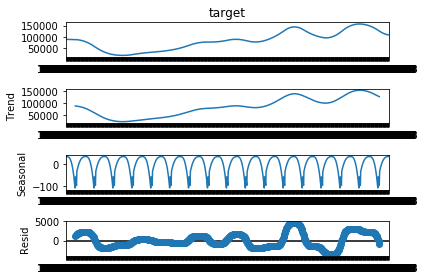

In [116]:

# plot decomposition
decomposed_result.plot();

We see evidence of seasonality clearly. This makes sense as the salmon return the same time very year in a seasonal cycle

In [112]:
df['target'].describe()

count       888.000000
mean      84108.673393
std       39323.202037
min       19693.749745
25%       49562.395410
50%       84013.614026
75%      112197.270234
max      156837.825898
Name: target, dtype: float64

The seaonal fluctuations are greater than one standard deviation, so we need to incorporate seasonality into our model.

In [114]:
order = (3, 1, 0)
seasonal_order = (3, 1, 0, 52)

# instantiate
sarimax = SARIMAX(
    y, 
    Z,
    order = order, 
    seasonal_order = seasonal_order, 
    #freq = "W", # freq helps set the index column of predictions
    enforce_stationarity = False
    # ensure model is not trying to enfore stationarity (use d and D)
)

# fit
sarimax = sarimax.fit() # stats model returns fitted model



/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [118]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             target   No. Observations:                  888
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 52)   Log Likelihood               -4561.356
Date:                            Sun, 07 Jun 2020   AIC                           9172.712
Time:                                    16:30:49   BIC                           9285.617
Sample:                                01-03-1999   HQIC                          9216.427
                                     - 01-03-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC1          376.5880    102.349      3.679      0.000     175.987     577.189
PC2         -162.7201     53.492     -3.042      0.002    -267.563     -57.877
PC3         -374.2014     57.480     -6.510      0.000    -486.860    -261.542
PC4         -712.9460    115.466     -6.175      0.000    -939.255    -486.637
PC5          333.8737     77.678      4.298      0.000     181.628     486.120
PC6         -880.4888     79.571    -11.065      0.000   -1036.445    -724.532
PC7         -351.7888     75.110     -4.684      0.000    -499.002    -204.576
PC8          218.1544     70.139      3.110      0.002      80.684     355.624
PC9         -926.5584     94.839     -9.770      0.000   -1112.439    -740.677
PC10         201.2461     97.511      2.064      0.039      10.128     392.364
PC11        -642.2977    126.247     -5.088      0.000    -889.738    -394.858
PC12        -130.6929    103.125     -1.267      0.205    -332.815      71.429
PC13         -21.9898     18.148     -1.212      0.226     -57.560      13.580
PC14        -531.6816    131.351     -4.048      0.000    -789.124    -274.239
PC15         730.5785    108.958      6.705      0.000     517.025     944.132
PC16        -645.4537     51.751    -12.472      0.000    -746.883    -544.024
PC17         -84.7717     92.470     -0.917      0.359    -266.010      96.467
PC18         166.7881     67.784      2.461      0.014      33.934     299.642
ar.L1          0.3567      0.018     19.781      0.000       0.321       0.392
ar.L2          0.3895      0.020     19.925      0.000       0.351       0.428
ar.L3          0.1617      0.033      4.941      0.000       0.098       0.226
ar.S.L52      -0.7092      0.021    -34.105      0.000      -0.750      -0.668
ar.S.L104     -0.6967      0.022    -31.114      0.000      -0.741      -0.653
ar.S.L156     -0.4162      0.017    -24.414      0.000      -0.450      -0.383
sigma2      3.987e+04   3306.322     12.059      0.000    3.34e+04    4.64e+04
===================================================================================
Ljung-Box (Q):                      114.52   Jarque-Bera (JB):             12734.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.77   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [119]:

# Setting up an in-sample train/test split
starting_index = round(len(y.index) * .8) # starting split after 80% of observations are in "training" set

sarimax_train = y.iloc[:starting_index]

sarimax_test  = y.iloc[starting_index:]

This time we are using the later half of our range to generate split our data into train and testing sets. The first 80% will be the test set and the later 20% will be the test set.

In [120]:
sarimax_train_preds = sarimax.predict(start = sarimax_train.index[0], end = sarimax_train.index[-1], exog = Z, typ = "levels")

In [121]:
sarimax_test_preds  = sarimax.predict(start = sarimax_test.index[0], 
                                           end = sarimax_test.index[-1], 
                                           exog = Z,
                                           typ = "levels",
                                           dynamic = False)

In [124]:
print(f'SARIMAX train RMSE is {rmse(sarimax_train[sarimax_train_preds.index],sarimax_train_preds)}')
print(f'SARIMAX test RMSE is {rmse(sarimax_test[sarimax_test_preds.index],sarimax_test_preds)}')

SARIMAX train RMSE is 4753.039066732567
SARIMAX test RMSE is 207.85107292950184


The Model performs unbelievably accurately. Coming within 207$ on avg of the real values.

# SARIMA Full Data

In [125]:
price = pd.read_csv("data/permit_price.csv",parse_dates=["Year"], index_col = ["Year"])


Since we had to incorporate exogenous values, we had limit our target to 1999-2016. Now we are going to model to 2020 and even generate a forescast for 2020-2025 using the full values from 1984-2019.


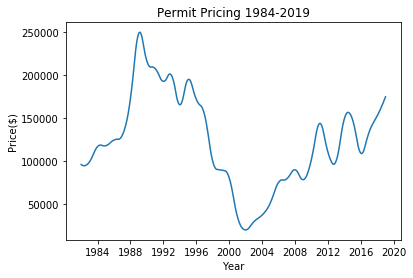

In [126]:
plt.title("Permit Pricing 1984-2019")
plt.plot(price)
plt.ylabel("Price($)")
plt.xlabel("Year");


We can see the price fluctuation for the whole period on record.

In [127]:
sarima = SARIMAX(
    price, 
    order = order, 
    seasonal_order = seasonal_order, 
    freq = "W", # freq helps set the index column of predictions
    enforce_stationarity = False
    # ensure model is not trying to enfore stationarity (use d and D)
)

# fit
sarima = sarima.fit()

/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [128]:
starting_index = round(len(price) * .8) # starting split after 80% of observations are in "training" set

sarima_train = price.iloc[:starting_index,:]

sarima_test  = price.iloc[starting_index:,:]

We segment the first 80% and later 20% as train and test respectively

In [129]:
sarima_train_preds = sarima.predict(start = sarima_train.index[0], end = sarima_train.index[-1],typ = "levels")
sarima_test_preds  = sarima.predict(start = sarima_test.index[0], 
                                           end = sarima_test.index[-1], 
                                           
                                           typ = "levels",
                                           dynamic = False)

We generate predictions over the train and test intervals

The predictions over the test interval mirror the real values very closely. Lets measure the RMSE over the period

In [130]:
print(f'SARIMAX train RMSE is {rmse(sarima_train,sarima_train_preds)}')
print(f'SARIMAX test RMSE is {rmse(sarima_test,sarima_test_preds)}')

SARIMAX train RMSE is 4084.8043081541273
SARIMAX test RMSE is 3.274829812917954


# VAR

In [154]:
def get_diff(column, thresh = .05):
    '''Returns differencing results of amount of differencing required to make column stationary'''
    col_copy = column.copy() # make copy to changes are not affecting original column object
    d = 0 # start with d = 0
    adf_result = interpret_dftest(col_copy) # conduct ADF test
    while (adf_result["p-value"] > thresh): # if above p-value threshold, continue differencing until stationary
        d += 1
        col_copy = col_copy.diff().dropna()
        adf_result = interpret_dftest(col_copy)
    adf_result["d"] = d
    return adf_result

We need to ensure statonarity for all of our features in order to fit our VAR model. So, we need to run a dickey fuller test on all of our features

In [167]:

# For each column in dataframe, print result from get_diff
for col in Z.columns:
    adf_result = get_diff(Z[col])
    print(f"{col} is stationary with d={adf_result['d']} at p-value = {round(adf_result['p-value'], 3)}")
          

PC1 is stationary with d=2.0 at p-value = 0.0
PC2 is stationary with d=2.0 at p-value = 0.0
PC3 is stationary with d=0.0 at p-value = 0.036
PC4 is stationary with d=2.0 at p-value = 0.0
PC5 is stationary with d=0.0 at p-value = 0.034
PC6 is stationary with d=0.0 at p-value = 0.004
PC7 is stationary with d=0.0 at p-value = 0.001
PC8 is stationary with d=0.0 at p-value = 0.001
PC9 is stationary with d=0.0 at p-value = 0.0
PC10 is stationary with d=0.0 at p-value = 0.0
PC11 is stationary with d=0.0 at p-value = 0.0
PC12 is stationary with d=0.0 at p-value = 0.0
PC13 is stationary with d=0.0 at p-value = 0.0
PC14 is stationary with d=0.0 at p-value = 0.0
PC15 is stationary with d=0.0 at p-value = 0.0
PC16 is stationary with d=0.0 at p-value = 0.0
PC17 is stationary with d=0.0 at p-value = 0.0
PC18 is stationary with d=0.0 at p-value = 0.0


In [168]:
Z['PC1'] = Z['PC1'].diff().diff()
Z['PC2'] = Z['PC2'].diff().diff()
Z['PC4'] = Z['PC4'].diff().diff()



Our function indentified these four features as being in need of differencing in order to achieve stationarity.

In the test set these features required differencing and so we added them back in with stationarity achieved

In [169]:
Z.dropna(inplace=True)


In [170]:
#_train[Z_train.index]
v = y[Z.index]
full = pd.merge(left = v,right = Z,left_index=True,right_index=True)

We added these back together after dropping empty colums then added our target variable to each and created a new dataframe with stationarity achieved with our target variables included.

In [177]:
var = VAR(full,freq = "W")

In [178]:
fitted_var = var.fit(maxlags=20, ic = "aic")

In [179]:
fitted_var.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 07, Jun, 2020
Time:                     17:23:17
--------------------------------------------------------------------
No. of Equations:         19.0000    BIC:                   -74.5515
Nobs:                     882.000    HQIC:                  -79.4507
Log likelihood:           14059.8    FPE:                1.51843e-36
AIC:                     -82.4839    Det(Omega_mle):     3.09560e-37
--------------------------------------------------------------------
Results for equation target
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.228194         0.245395            0.930           0.352
L1.target         3.344549         0.031001          107.887           0.000
L1.PC1           -3.669776         1.642847           -2.234           0.02

In [241]:


starting_index = round(len(full) * .8) # starting split after 80% of observations are in "training" set

var_train = full.iloc[:starting_index,:]

var_test  = full.iloc[starting_index:,:]

In [242]:
var_train_preds, lower_conf_ints, upper_conf_ints = fitted_var.forecast_interval(var_train.values, len(var_train))
var_test_preds, lower_conf_ints, upper_conf_ints = fitted_var.forecast_interval(var_train.values, len(var_test))

Get predictions for the test interval 

In [245]:
print(f'VAR Train RMSE is {rmse(var_train,var_train_preds)}')
print(f'VAR Test RMSE is {rmse(var_test,var_test_preds)}')

VAR Train RMSE is 34655.0511998083
VAR Test RMSE is 769.570490409739


It scored well, but did not outperform our Sarimax and Sarima Model

# RNN

I wanted to see if Recurent Neural Network could handle all 1306 features without PCA

In [204]:
train_sequences = TimeseriesGenerator(X_train_ss, y_train, length=52, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_ss, y_test, length=52, batch_size=64)

In [205]:
batch_x, batch_y = train_sequences[0]


In [206]:
model = Sequential()
model.add(GRU(8, input_shape=(52,1368), return_sequences=True))
model.add(GRU(8))

model.add(Dense(4, activation='relu'))

model.add(Dense(1, activation='linear'))

We have 4 layers here with a linear output layer, layer so our predictions will be in the right form. 

In [207]:
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

Our loss metric is Mean Squared Error

In [208]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 52, 8)             33072     
_________________________________________________________________
gru_3 (GRU)                  (None, 8)                 432       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 33,545
Trainable params: 33,545
Non-trainable params: 0
_________________________________________________________________


In [209]:
history = model.fit_generator(train_sequences, validation_data=test_sequences, epochs=10, verbose=1)

Epoch 1/10
11/11 [==============================] - 3s 265ms/step - loss: 6299452416.0000 - mse: 6299452416.0000 - val_loss: 19956658176.0000 - val_mse: 19956658176.0000
Epoch 2/10
11/11 [==============================] - 2s 177ms/step - loss: 6299386880.0000 - mse: 6299386880.0000 - val_loss: 19956459520.0000 - val_mse: 19956457472.0000
Epoch 3/10
11/11 [==============================] - 1s 135ms/step - loss: 6299331584.0000 - mse: 6299331584.0000 - val_loss: 19956344832.0000 - val_mse: 19956344832.0000
Epoch 4/10
11/11 [==============================] - 1s 120ms/step - loss: 6299277824.0000 - mse: 6299277824.0000 - val_loss: 19956277248.0000 - val_mse: 19956277248.0000
Epoch 5/10
11/11 [==============================] - 1s 113ms/step - loss: 6299245568.0000 - mse: 6299245568.0000 - val_loss: 19956195328.0000 - val_mse: 19956195328.0000
Epoch 6/10
11/11 [==============================] - 1s 113ms/step - loss: 6299206144.0000 - mse: 6299206144.0000 - val_loss: 19956123648.0000 - val_ms

In [210]:
model.predict(test_sequences)

array([[2.7944942],
       [2.7943246],
       [2.7942393],
       [2.7940252],
       [2.793826 ],
       [2.7936585],
       [2.7935498],
       [2.7934785],
       [2.7933981],
       [2.7933607],
       [2.7933457],
       [2.7933552],
       [2.7934027],
       [2.793432 ],
       [2.7935102],
       [2.7936065],
       [2.7937255],
       [2.7938292],
       [2.793959 ],
       [2.7940927],
       [2.7942297],
       [2.7943742],
       [2.7944577],
       [2.794585 ],
       [2.7946882],
       [2.7947714],
       [2.7948363],
       [2.7948892],
       [2.794932 ],
       [2.7949646],
       [2.7949908],
       [2.7950099],
       [2.795024 ],
       [2.7950325],
       [2.7950401],
       [2.7950406],
       [2.7950382],
       [2.7950327],
       [2.7950215],
       [2.7950132],
       [2.7949975],
       [2.794977 ],
       [2.7949429],
       [2.7948956],
       [2.794819 ],
       [2.7947652],
       [2.7947712],
       [2.7948148],
       [2.7948816],
       [2.7949734],


Didnt output predictions that were usable, possibly too many features, we need to retry with our PCA features.

In [217]:
Z_test.shape

(710, 23)

In [223]:
train_sequences = TimeseriesGenerator(Z_train, y_train, length=52, batch_size=64)
test_sequences = TimeseriesGenerator(Z_test, y_test, length=52, batch_size=64)

In [224]:
batch_x, batch_y = train_sequences[0]

In [228]:
model = Sequential()
model.add(GRU(8, input_shape=(52,23), return_sequences=True,kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(GRU(8))

model.add(Dense(4, activation='relu'))

model.add(Dense(1, activation='linear'))

We are running it for 10k epochs, so I added some regularizations and an early stop, to prevent overfitting.

In [229]:
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
early_stop = EarlyStopping(monitor='val_mse', min_delta=0, patience=5, verbose=1, mode='auto')

In [230]:
history = model.fit_generator(train_sequences, validation_data=test_sequences, epochs=10,callbacks=[early_stop],verbose=1)

Epoch 1/10
11/11 [==============================] - 2s 139ms/step - loss: 6299406336.0000 - mse: 6299406336.0000 - val_loss: 19956658176.0000 - val_mse: 19956658176.0000
Epoch 2/10
11/11 [==============================] - 1s 67ms/step - loss: 6299400192.0000 - mse: 6299400192.0000 - val_loss: 19956637696.0000 - val_mse: 19956637696.0000
Epoch 3/10
11/11 [==============================] - 1s 64ms/step - loss: 6299390976.0000 - mse: 6299390976.0000 - val_loss: 19956615168.0000 - val_mse: 19956615168.0000
Epoch 4/10
11/11 [==============================] - 1s 64ms/step - loss: 6299382272.0000 - mse: 6299382272.0000 - val_loss: 19956600832.0000 - val_mse: 19956600832.0000
Epoch 5/10
11/11 [==============================] - 1s 66ms/step - loss: 6299371520.0000 - mse: 6299371520.0000 - val_loss: 19956588544.0000 - val_mse: 19956588544.0000
Epoch 6/10
11/11 [==============================] - 1s 67ms/step - loss: 6299357184.0000 - mse: 6299357184.0000 - val_loss: 19956576256.0000 - val_mse: 19

In [233]:
rnn_test_preds = model.predict(test_sequences)


Again, it didn't output usable predictions

# Model Selection

|   Model   | 80% RMSE | 20% RMSE|
|-----------|----------|---------|
| Linear Regression    | 11,000   | 2 X 10**16  |
| LASSO   | 4700  | 150000|
| ARIMAX   |3.6    |3.55|
| SARIMAX   |4700  |207|
| Var  |34000    |769|
| SARIMA   |4084  |3.27|


# Model Evaluation 

In [289]:
y.index = pd.to_datetime(y.index, format='%Y/%m/%d')

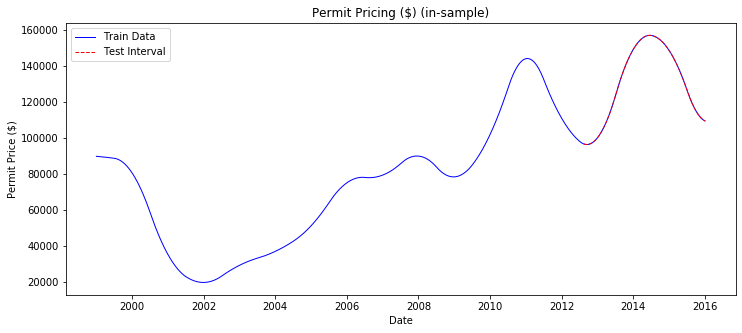

In [296]:
plt.figure(figsize=(12,5))
plt.title("Permit Pricing ($) (in-sample)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(arimax_test_preds.index, arimax_test_preds, lw=1, color='red', ls='dashed', label='Test Interval')

#  labels
plt.xlabel("Date")
plt.ylabel("Permit Price ($)")

# legend
plt.legend(loc = "upper left");

We were really accurate but we cannot get a forecast without exog variables past our data set. We need to bring in our SARIMA model and use to forecast past our current date.

# SARIMA Evaluation

In [367]:
# get forecast object
forecast_object = sarima.get_forecast(steps = len(sarima_test))

# grab forecasted values
forecast_pred_values = forecast_object.predicted_mean
# converting to pandas Seried with proper datetime index
forecast_preds = pd.Series(forecast_pred_values, index = y_test.index)

# grab confidence intervals
pred_ci = forecast_object.conf_int()

# break out lower and upper confidence values
lower_conf_int = pred_ci.iloc[:,0]
upper_conf_int = pred_ci.iloc[:,1]

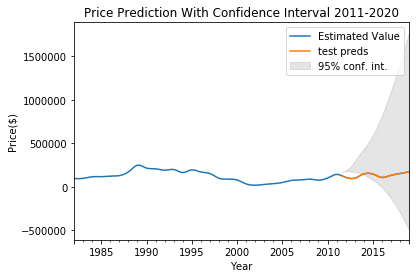

In [371]:
price.plot(label = 'True Value')
sarima_test_preds.plot(label="test preds ")

plt.fill_between(sarima_test.index, lower_conf_int, upper_conf_int, color='k', alpha=0.1,  label ="95% conf. int.")
plt.legend()
plt.title("Price Prediction With Confidence Interval 2011-2020")
plt.ylabel("Price($)")
plt.xlabel("Year");
          



We were very close to the real values over the period from 2011-2020, but with a very large confidence interval.

In [356]:
def plot_SARIMAX_predictions(y_train, y_test = None, train_preds = None, test_preds = None, lower_conf_int = None, upper_conf_int = None, title = "Title", ylabel = "{y_label}",xlabel = "Data"):
    plt.figure(figsize=(12,5))
    plt.title(title)

    # train data
    plt.plot(y_train.index, y_train, lw=1, color='purple', ls='solid', label='Train Data')

    # train prediction
    if train_preds is not None:
        plt.plot(train_preds.index, train_preds, lw=1, color='green', ls='dashed', label='Training Predictions')

    # test data
    if y_test is not None:
        plt.plot(y_test.index, y_test, lw=1, color='blue', ls='solid',label='Test Data')

    # test predictions
    if test_preds is not None:
        plt.plot(test_preds.index, test_preds, lw=1, color='red', ls='dashed',label='Testing Predictions')

    #  labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # confidence intervals
    if lower_conf_int is not None and upper_conf_int is not None:
        plt.fill_between(y_test.index, lower_conf_int, upper_conf_int, color='k', alpha=0.1,  label ="95% conf. int.");
    # legend
    plt.legend(loc = "upper left");
# Found at Mahdi Shadkam-Farrokhi https://git.generalassemb.ly/DSI-US-11/local_sarimax/blob/master/sarimax_SOLUTION.ipynb

In [357]:

# get forecast object
forecast_object = sarima.get_forecast(steps = len(test))

# grab forecasted values
forecast_pred_values = forecast_object.predicted_mean
# converting to pandas Seried with proper datetime index
forecast_preds = pd.Series(forecast_pred_values, index = y_test.index)

# grab confidence intervals
pred_ci = forecast_object.conf_int()

# break out lower and upper confidence values
lower_conf_int = pred_ci.iloc[:,0]
upper_conf_int = pred_ci.iloc[:,1]

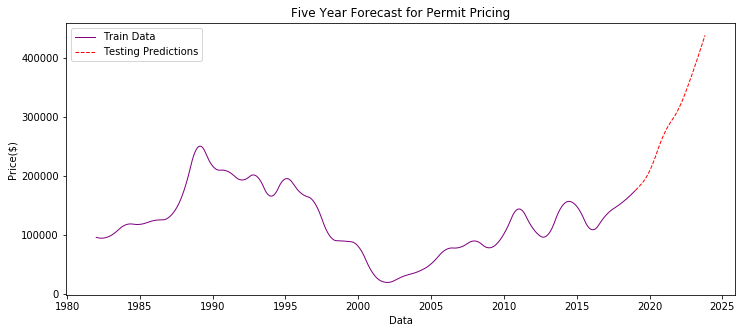

In [358]:
five_year = sarima.forecast(steps=250)
plot_SARIMAX_predictions(
    price,  
    test_preds = five_year,
    title = "Five Year Forecast for Permit Pricing",
    ylabel = "Price($)"
   
)

The permits are projected to double in value over the period 2020-2025.
But what is the confidence interval for this?

In [359]:
# get forecast object
forecast_object = sarima.get_forecast(steps=250)

# grab forecasted values
forecast_pred_values = forecast_object.predicted_mean
# converting to pandas Seried with proper datetime index
forecast_preds = pd.Series(forecast_pred_values, index = y_test.index)

# grab confidence intervals
pred_ci = forecast_object.conf_int()

# break out lower and upper confidence values
lower_conf_int = pred_ci.iloc[:,0]
upper_conf_int = pred_ci.iloc[:,1]

<Figure size 1440x576 with 0 Axes>

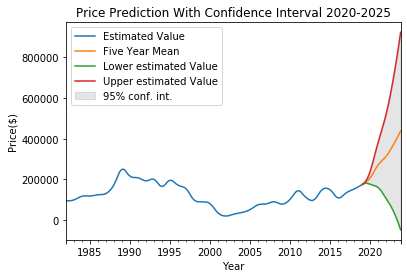

In [360]:
plt.figure(figsize=(20,8))
price.plot(label = 'True Value')
five_year.plot(label="Five Year Mean ")
lower_conf_int.plot(label = 'Lower estimated Value')
upper_conf_int.plot(label = 'Upper estimated Value')
plt.fill_between(five_year.index, lower_conf_int, upper_conf_int, color='k', alpha=0.1,  label ="95% conf. int.")
plt.legend()
plt.title("Price Prediction With Confidence Interval 2020-2025")
plt.ylabel("Price($)")
plt.xlabel("Year");
          


The confidence Interval is quite large and so we cannot be that confident that our price will go up. It looks like the price could either drop in value or quadruple in value. However, It will most likely go up based on the mean trend in the data.

# Conclusions/Recommendations

Although the models we ran had a wide confidence interval, given the strength of the industry as a whole and resiliency we have seen we are comfortable going ahead with the purchase.
The Arimax model handled the exogenous variables the best, but in the end the SARIMA outperformed it. Too many features added noise to the model and ended up skewing the results, but we did get a good sense of the features that were correlative for us in making our prediction.

Moving forward, I would remove some of the fish production and consumption data and only focus on features that really add variance. 
